# Expedia predict destination : 
The goal of this Kaggle competition is to predit the hotel of user

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import xgboost as xgb
%matplotlib inline 

# Explore and vizualise data : 

In [59]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv",nrows=90000)
destinations = pd.read_csv("destinations.csv")
submission = pd.read_csv("sample_submission.csv")
target = train.hotel_cluster

In [3]:
print "We have",train.shape[0], "train values and",train.shape[1],"variables "

We have 90000 train values and 24 variables 


In [128]:
test.info()
id = np.empty(2528243)
for i in range(2528243):
    id[i] = int(i)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528243 entries, 0 to 2528242
Data columns (total 18 columns):
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtypes: float64(1), int64(17)
memory usage: 366.5 MB


In [138]:
id = np.array(id, dtype=np.int32)

In [19]:
test.srch_ci.isnull() == True

0          False
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9          False
10         False
11         False
12         False
13         False
14         False
15         False
16         False
17         False
18         False
19         False
20         False
21         False
22         False
23         False
24         False
25         False
26         False
27         False
28         False
29         False
           ...  
2528213    False
2528214    False
2528215    False
2528216    False
2528217    False
2528218    False
2528219    False
2528220    False
2528221    False
2528222    False
2528223    False
2528224    False
2528225    False
2528226    False
2528227    False
2528228    False
2528229    False
2528230    False
2528231    False
2528232    False
2528233    False
2528234    False
2528235    False
2528236    False
2528237    False
2528238    False
2528239    False
2528240    Fal

In [64]:
train.orig_destination_distance.fillna(0,inplace=True)
test.orig_destination_distance.fillna(0,inplace=True)

In [65]:
hotel_nights = pd.to_datetime(train['srch_co']) - pd.to_datetime(train['srch_ci']) 
hotel_nights = (hotel_nights / np.timedelta64(1, 'D')).astype(float) # convert to float to avoid NA problems
train['hotel_nights'] = hotel_nights

#hotel_nights_test = pd.to_datetime(test['srch_co']) - pd.to_datetime(test['srch_ci']) 
#hotel_nights_test = (hotel_nights_test / np.timedelta64(1, 'D')).astype(float) # convert to float to avoid NA problems
#test['hotel_nights'] = hotel_nights_test

In [66]:
train = train.drop('date_time',1)
train = train.drop('srch_co',1)
train = train.drop('srch_ci',1)

test = test.drop('date_time',1)
test = test.drop('srch_co',1)
test = test.drop('srch_ci',1)

In [67]:
train.hotel_nights.fillna(0,inplace=True)
train[train.hotel_nights <0] = 0
test.hotel_nights.fillna(0,inplace=True)
test[test.hotel_nights <0] = 0

AttributeError: 'DataFrame' object has no attribute 'hotel_nights'

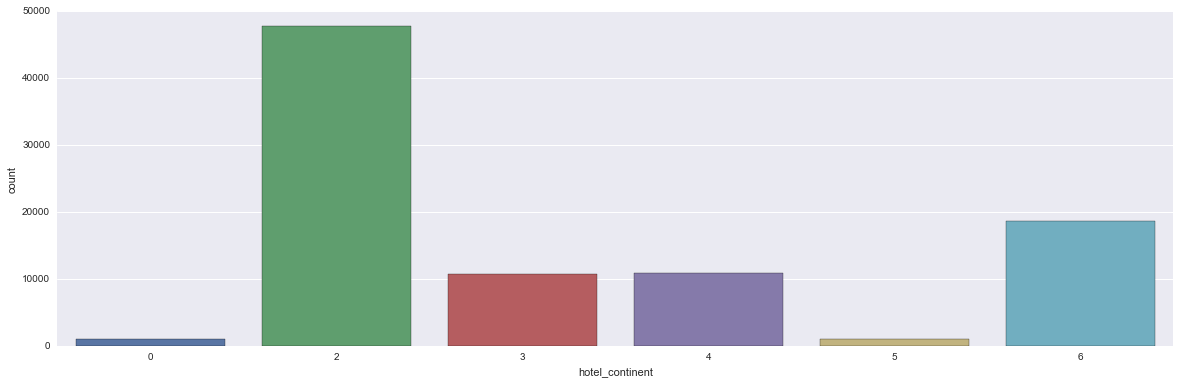

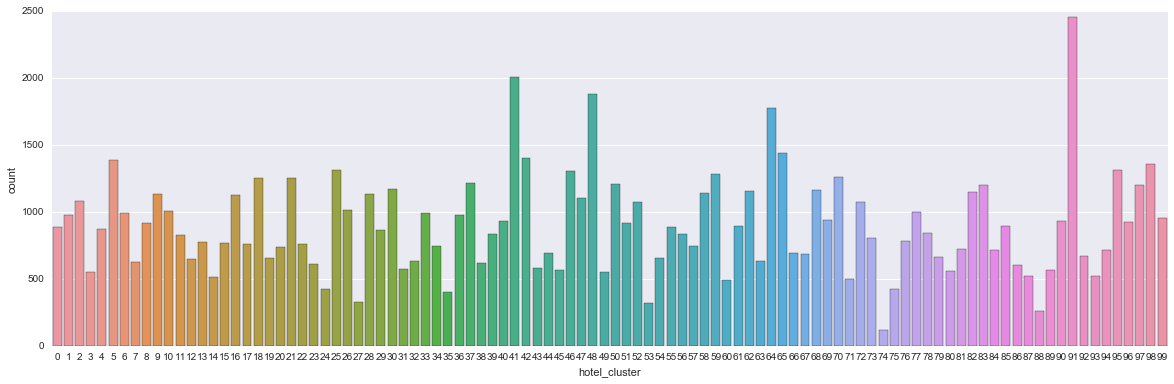

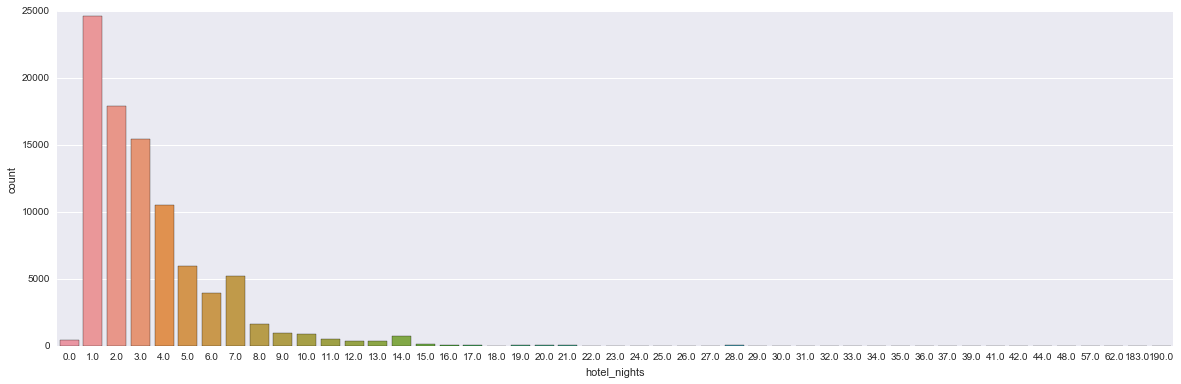

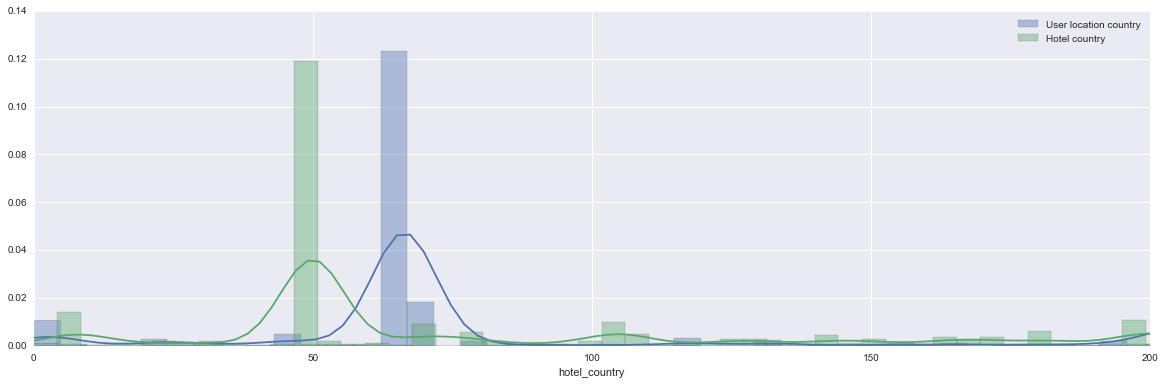

In [68]:
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_continent)
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_cluster)
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_nights)
plt.figure(figsize=(20,6))
sns.distplot(train.user_location_country,label="User location country")
sns.distplot(train.hotel_country,label="Hotel country")
plt.xlim([0,200])
plt.legend()

We notice that most of booking is from continent 2, and the most reccurent hotel cluster is the cluster 91 and 41

In [69]:
print "The average of booking nights is : ",np.mean(train.hotel_nights)," nights by user"

The average of booking nights is :  3.39924444444  nights by user


In [70]:
columns = train.columns
for col in columns : 
    if(train[col].dtype !='object'):
        print col
        print(train[col].corr(train['hotel_cluster']))

site_name
-0.016331262939
posa_continent
-0.000586731043576
user_location_country
-0.025290379734
user_location_region
0.0091683672969
user_location_city
-0.00688258854375
orig_destination_distance
0.00477310086855
user_id
0.000326186216411
is_mobile
-0.00312898951913
is_package
0.049849872666
channel
-0.00918971743407
srch_adults_cnt
0.00728056310214
srch_children_cnt
0.00460243314172
srch_rm_cnt
-0.00439388138857
srch_destination_id
-0.00800205523856
srch_destination_type_id
-0.0301045016576
is_booking
-0.025099666836
cnt
-0.000781390942775
hotel_continent
-0.00735586779838
hotel_country
-0.0227988426757
hotel_market
0.0338226164757
hotel_cluster
1.0
hotel_nights
0.0435817065353


In [71]:
lda = LDA(n_components = 2)
X_r = lda.fit(train,target).transform(train)

In [72]:
X_r

array([[-152.98326379,   -0.89227439],
       [-152.98744593,   -0.90782221],
       [-152.96740592,   -0.85236652],
       ..., 
       [  69.9723325 ,   -1.07064543],
       [ -52.51374139,   -1.13496166],
       [ -27.38124339,   -0.65478074]])

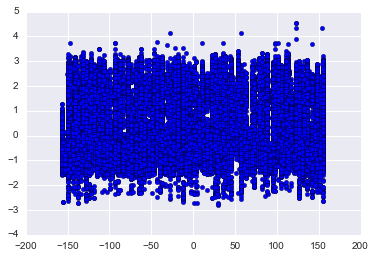

In [73]:
x = X_r[:,0]
y = X_r[:,1]
plt.scatter(x, y)
plt.figure(figsize=(20,10)) 
plt.show()

In [74]:
train = train.drop('hotel_cluster',1)
train = train.drop('hotel_nights',1)

In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528243 entries, 0 to 2528242
Data columns (total 19 columns):
id                           int64
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtypes: float64(1), int64(18)
memory usage: 385.8 MB


In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 0 to 89999
Data columns (total 20 columns):
site_name                    90000 non-null int64
posa_continent               90000 non-null int64
user_location_country        90000 non-null int64
user_location_region         90000 non-null int64
user_location_city           90000 non-null int64
orig_destination_distance    90000 non-null float64
user_id                      90000 non-null int64
is_mobile                    90000 non-null int64
is_package                   90000 non-null int64
channel                      90000 non-null int64
srch_adults_cnt              90000 non-null int64
srch_children_cnt            90000 non-null int64
srch_rm_cnt                  90000 non-null int64
srch_destination_id          90000 non-null int64
srch_destination_type_id     90000 non-null int64
is_booking                   90000 non-null int64
cnt                          90000 non-null int64
hotel_continent              90000 non-

In [77]:
train = train.drop('is_booking',1)
train = train.drop('cnt',1)
test = test.drop('id',1)

In [78]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
model.fit(train, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [79]:
predicts = model.predict(test)

In [139]:
predicts = [ ceil(x) for x in predicts ]
predicts = [ int(x) for x in predicts ]

In [140]:
submission = pd.DataFrame({"id":id, "hotel_cluster":predicts})
submission.to_csv("submission_rfc.csv", index=False)

In [141]:
rfs = pd.read_csv("submission_rfc.csv")

TypeError: 'module' object is not callable